## 汇聚层
通常当我们处理图像时，我们希望逐渐降低隐藏表⽰的空间分辨率、聚集信息，这样随着我们在神经⽹络中
层叠的上升，每个神经元对其敏感的感受野（输⼊）就越⼤。  

⽽我们的机器学习任务通常会跟全局图像的问题有关（例如，“图像是否包含⼀只猫呢？”），所以我们最后⼀
层的神经元应该对整个输⼊的全局敏感。通过逐渐聚合信息，⽣成越来越粗糙的映射，最终实现学习全局表
⽰的⽬标，同时将卷积图层的所有优势保留在中间层。  

此外，当检测较底层的特征时（例如之前所讨论的边缘），我们通常希望这些特征保持某种程度上的平
移不变性。例如，如果我们拍摄⿊⽩之间轮廓清晰的图像X，并将整个图像向右移动⼀个像素，即Z[i, j] =
X[i, j + 1]，则新图像Z的输出可能⼤不相同。  

本节将介绍汇聚（pooling）层，它具有双重⽬的：降低卷积层对位置的敏感性，同时降低对空间降采样表⽰
的敏感性。

## 最大汇聚层和平均汇聚层
与卷积层类似，汇聚层运算符由⼀个固定形状的窗⼝组成，该窗⼝根据其步幅⼤⼩在输⼊的所有区域上滑动，
为固定形状窗⼝（有时称为汇聚窗⼝）遍历的每个位置计算⼀个输出。然⽽，不同于卷积层中的输⼊与卷积
核之间的互相关计算，汇聚层不包含参数。相反，池运算是确定性的，我们通常计算汇聚窗⼝中所有元素的
最⼤值或平均值。这些操作分别称为最⼤汇聚层（maximum pooling）和平均汇聚层（average pooling）。

在这两种情况下，与互相关运算符⼀样，汇聚窗⼝从输⼊张量的左上⻆开始，从左往右、从上往下的在输⼊
张量内滑动。在汇聚窗⼝到达的每个位置，它计算该窗⼝中输⼊⼦张量的最⼤值或平均值。计算最⼤值或平
均值是取决于使⽤了最⼤汇聚层还是平均汇聚层。  
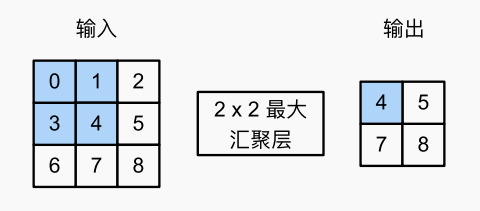  
汇聚窗⼝形状为 2 × 2 的最⼤汇聚层。着⾊部分是第⼀个输出元素，以及⽤于计算这个输出的输⼊元
素: max(0, 1, 3, 4) = 4.

图中的输出张量的⾼度为2，宽度为2。这四个元素为每个汇聚窗⼝中的最⼤值：  
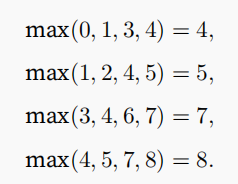

汇聚窗⼝形状为p × q的汇聚层称为p × q汇聚层，汇聚操作称为p × q汇聚。  
在下⾯的代码中的pool2d函数，我们实现汇聚层的前向传播。这类似于 6.2节中的corr2d函数。然⽽，这⾥我
们没有卷积核，输出为输⼊中每个区域的最⼤值或平均值。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [2]:
# 输⼊张量X，验证⼆维最⼤汇聚层的输出
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [3]:
# 验证平均汇聚层
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## 填充和步幅
与卷积层⼀样，汇聚层也可以改变输出形状。和以前⼀样，我们可以通过填充和步幅以获得所需的输出形状。
下⾯，我们⽤深度学习框架中内置的⼆维最⼤汇聚层，来演⽰汇聚层中填充和步幅的使⽤。我们⾸先构造了
⼀个输⼊张量X，它有四个维度，其中样本数和通道数都是1。  


In [4]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的步幅与汇聚窗⼝的⼤⼩相同。因此，如果我们使⽤形状为(3, 3)的汇聚窗⼝，
那么默认情况下，我们得到的步幅形状为(3, 3)。

In [5]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [6]:
# 填充和步幅可以⼿动设定
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [7]:
# 可以设定⼀个任意⼤⼩的矩形汇聚窗⼝，并分别设定填充和步幅的⾼度和宽度
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 多个通道
在处理多通道输⼊数据时，汇聚层在每个输⼊通道上单独运算，⽽不是像卷积层⼀样在通道上对输⼊进⾏汇
总。这意味着汇聚层的输出通道数与输⼊通道数相同。下⾯，我们将在通道维度上连结张量X和X + 1，以构
建具有2个通道的输⼊。

In [8]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [9]:
# 汇聚后输出通道的数量仍然是2
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 小结
* 对于给定输⼊元素，最⼤汇聚层会输出该窗⼝内的最⼤值，平均汇聚层会输出该窗⼝内的平均值。
* 汇聚层的主要优点之⼀是减轻卷积层对位置的过度敏感。
* 我们可以指定汇聚层的填充和步幅。
* 使⽤最⼤汇聚层以及⼤于1的步幅，可减少空间维度（如⾼度和宽度）。
* 汇聚层的输出通道数与输⼊通道数相同。